In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Check columns
inspector = inspect(engine)
columns_measurement = inspector.get_columns('Measurement')
for c in columns_measurement:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
last_date = engine.execute('select max(date) from Measurement').fetchall()[0][0]
print(last_date)
last_date_query = dt.datetime.strptime(last_date, '%Y-%m-%d')
print(last_date_query)

2017-08-23
2017-08-23 00:00:00


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = last_date_query - dt.timedelta(days = 366)
print(query_date)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).filter(Measurement.date <= last_date_query).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data).set_index('date')

# Sort the dataframe by date
precip_df_sorted = precip_df.sort_values(by = 'date').dropna()

# Rename prcp
precip_df_renamed = precip_df_sorted.rename(columns = {'prcp' : 'precipitation'})
precip_df_renamed.head(50)


2016-08-22 00:00:00


,precipitation
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28


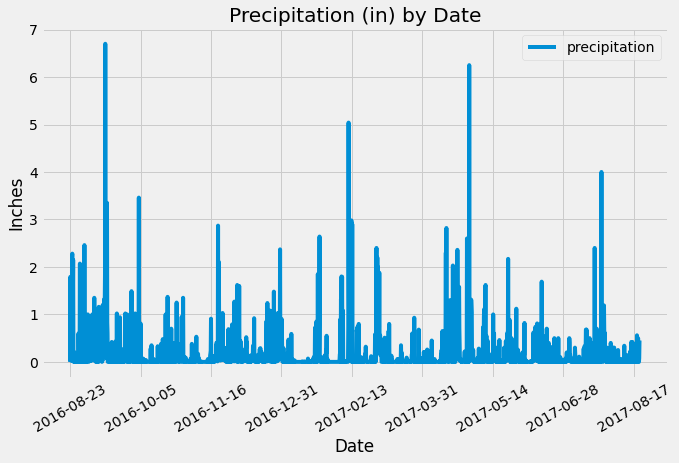

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df_renamed.plot(title = "Precipitation (in) by Date", xlabel = 'Date', ylabel = 'Inches', figsize = (10, 6), rot = 30)
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df_renamed.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Check columns
inspector = inspect(engine)
columns_stations = inspector.get_columns('Measurement')
for c in columns_stations:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [17]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.id).count()
print(station_count)

9


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Print most active station.
most_active = station_activity[0][0]
print(most_active)

# Calculate the lowest, highest, and average temperature
most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()
print(most_active_temps)

USC00519281
[(54.0, 85.0, 71.66378066378067)]


<AxesSubplot:title={'center':'Station USC00519281 Temperatures'}, ylabel='Frequency'>

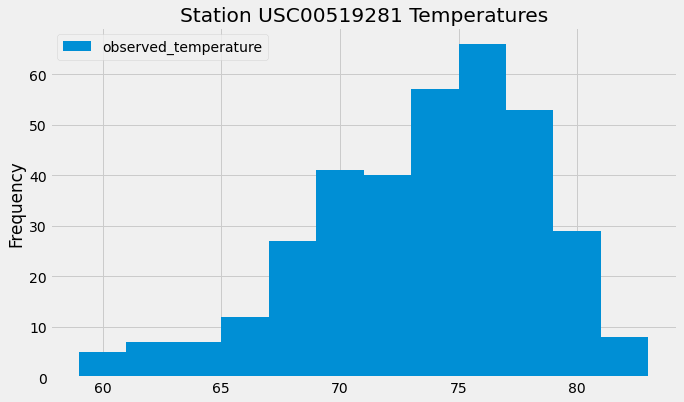

In [37]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= query_date).filter(Measurement.date <= last_date_query).filter(Measurement.station == most_active).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
station_df = pd.DataFrame(station_data).set_index('date')

# Sort the dataframe by date
station_df_sorted = station_df.sort_values(by = 'date').dropna()

# Rename prcp
station_df_renamed = station_df_sorted.rename(columns = {'tobs' : 'observed_temperature'})
station_df_renamed.head(50)

# Create histogram
station_df_renamed.plot.hist(xlabel = 'Temperature', ylabel = 'Frequency', title = 'Station USC00519281 Temperatures', figsize = (10,6), bins = 12)


# Close session

In [38]:
# Close Session
session.close()